In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression, SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC # C3
from sklearn.svm import LinearSVC # C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Analysis ###
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV , mutual_info_classif

### Custom Modules ###
from functions.data_types import optimize_dtypes
from functions.dataframe_actions import df_info, df_clean, show_value_counts, fill_missing_values
from functions.ml_training import train_classifiers, train_classifiers_tuned

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(working_memory=1024*20) 

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.decomposition import PCA

/home/lazaros/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


* PCA
* t-SNE
* Binning

In [2]:
# to read .csv files from another directory
data_location = "../Data/" # "/<path>"

df_mapped = pd.read_csv(data_location + "train_filled_mapped.csv")
df_mapped = optimize_dtypes(df_mapped)
# df_mapped.head()

In [3]:
# Separate target variable from feature variables
X_mapped = df_mapped.drop('HadHeartAttack', axis=1, inplace=False)  # Features
y_mapped = df_mapped['HadHeartAttack']   

In [4]:
original_dtypes = X_mapped.dtypes

X_mapped_scaled = (X_mapped - X_mapped.min(axis=0)) / (X_mapped.max(axis=0)-X_mapped.min(axis=0))              # min max scale
# X_mapped_scaled = (X_mapped - X_mapped.mean())/X_mapped.std() # If we use StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled.hist(figsize=(16, 20), bins=30, edgecolor="black") # plot to show features after scaling
# plt.subplots_adjust()

# Cast back to original data types
for column, dtype in original_dtypes.items():
    X_mapped_scaled[column] = X_mapped_scaled[column].astype(dtype)

## PCA

### PCA using all 38 features and reduce to 15 (as the number of selected features)

In [12]:
# *** Functions for creating principal components and plot variance ***
def apply_pca(X, n_components ,min_max_scale=True):
    # min_max_scale
    if min_max_scale:
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    # Create principal components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=13, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=100)
    return axs

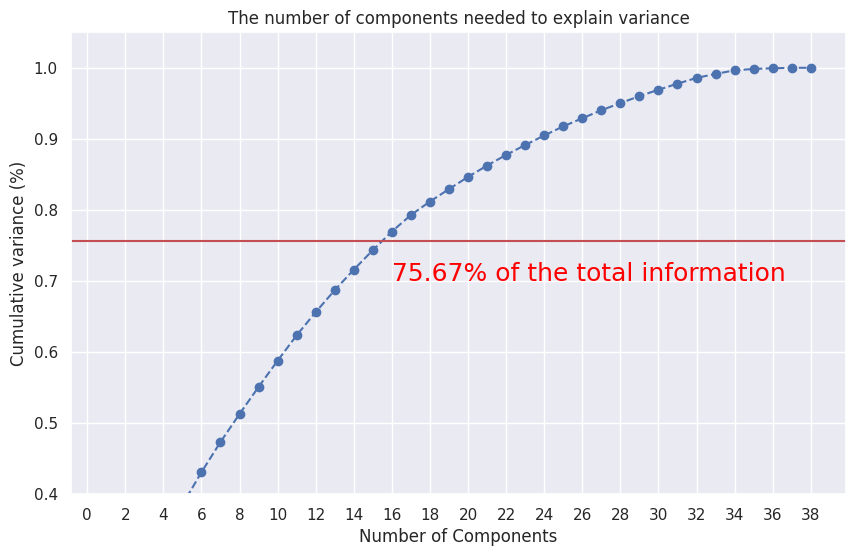

In [23]:
# pca with threshold
pca = PCA().fit(X_mapped_scaled)

# % matplotlib inline
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (10,6)

fig, ax = plt.subplots()
xi = np.arange(1, 39, step=1)
y_pca= np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.4,1.05)
plt.plot(xi, y_pca, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 39, step=2)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7567187205367067, color='r', linestyle='-')
plt.text(16, 0.7, '75.67% of the total information', color = 'red', fontsize=18)

ax.grid(axis='both')
plt.grid()
plt.show()

# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

In [14]:
X_mapped.isnull().sum().sum()

0

In [15]:
pca_15, X_pca_15, loadings_15 = apply_pca(X_mapped,15)
#loadings_10 #  loadings are the covariances/correlations between the original variables and the unit-scaled components

print(pca_15.explained_variance_ratio_)
print(pca_15.explained_variance_ratio_.sum())

[0.1371644  0.08417074 0.06786547 0.06337822 0.05844654 0.04595458
 0.04224649 0.04068005 0.03971083 0.03734804 0.03203228 0.02971729
 0.02846361 0.02603312 0.02350706]
0.7567187205367067


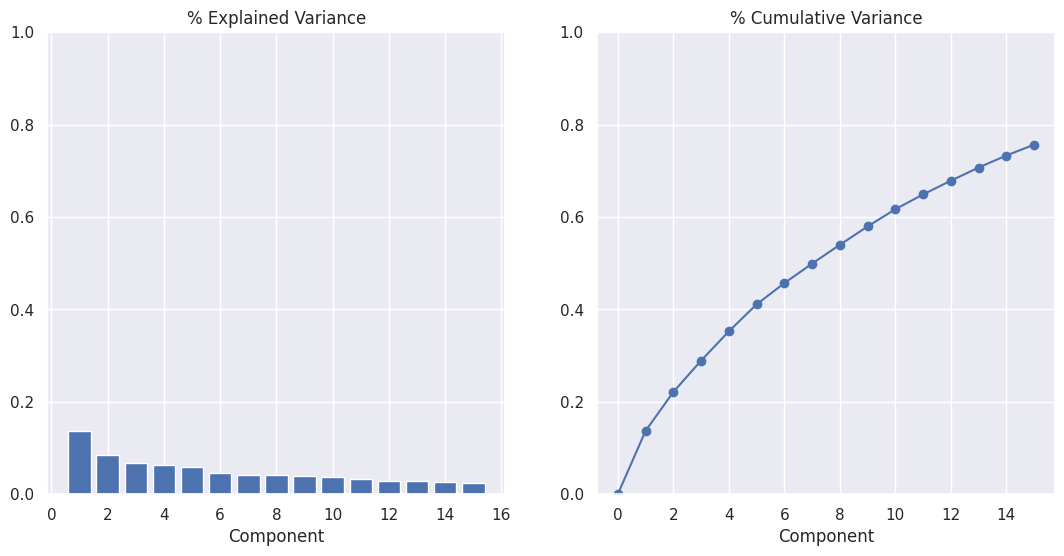

In [16]:
sns.set(style='darkgrid')
plot_variance(pca_15);

### PCA in the 15 selected features

In [17]:
df_selected = pd.read_csv(data_location + "train_mapped_selected.csv")
df_selected = optimize_dtypes(df_selected)
# df_selected.head()

In [18]:
# Separate target variable from feature variables
X_selected = df_selected.drop('HadHeartAttack', axis=1, inplace=False)  # Features
y_selected = df_selected['HadHeartAttack']   

In [19]:
original_dtypes = X_selected.dtypes

X_selected_scaled = (X_selected - X_selected.min(axis=0)) / (X_selected.max(axis=0)-X_selected.min(axis=0))              # min max scale
# X_selected_scaled = (X_mapped - X_mapped.mean())/X_mapped.std() # If we use StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled.hist(figsize=(16, 20), bins=30, edgecolor="black") # plot to show features after scaling
# plt.subplots_adjust()

# Cast back to original data types
for column, dtype in original_dtypes.items():
    X_selected_scaled[column] = X_selected_scaled[column].astype(dtype)

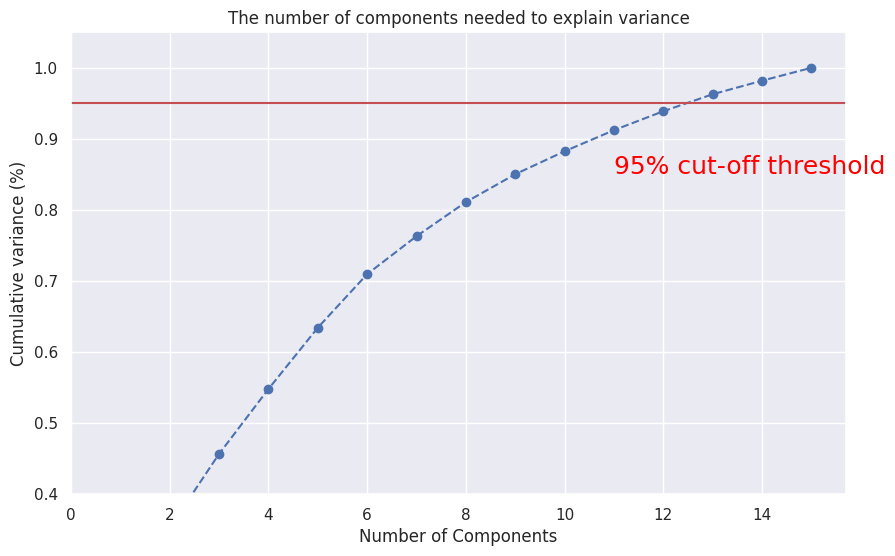

In [20]:
# pca with threshold
pca = PCA().fit(X_selected_scaled)

# % matplotlib inline
sns.set(font_scale = 1)
plt.rcParams["figure.figsize"] = (10,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y_pca= np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.4,1.05)
plt.plot(xi, y_pca, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 16, step=2)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(11, 0.85, '95% cut-off threshold', color = 'red', fontsize=18)

ax.grid(axis='both')
plt.grid()
plt.show()

# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

In [27]:
pca_13, X_pca_13, loadings_13 = apply_pca(X_selected,13)
#loadings_10 #  loadings are the covariances/correlations between the original variables and the unit-scaled components

print(pca_13.explained_variance_ratio_)
print(pca_13.explained_variance_ratio_.sum())

[0.24288232 0.10997467 0.10392431 0.09128295 0.08631277 0.07530161
 0.05338017 0.04802475 0.03918792 0.03229779 0.02966611 0.02665793
 0.02389888]
0.9627921884760263


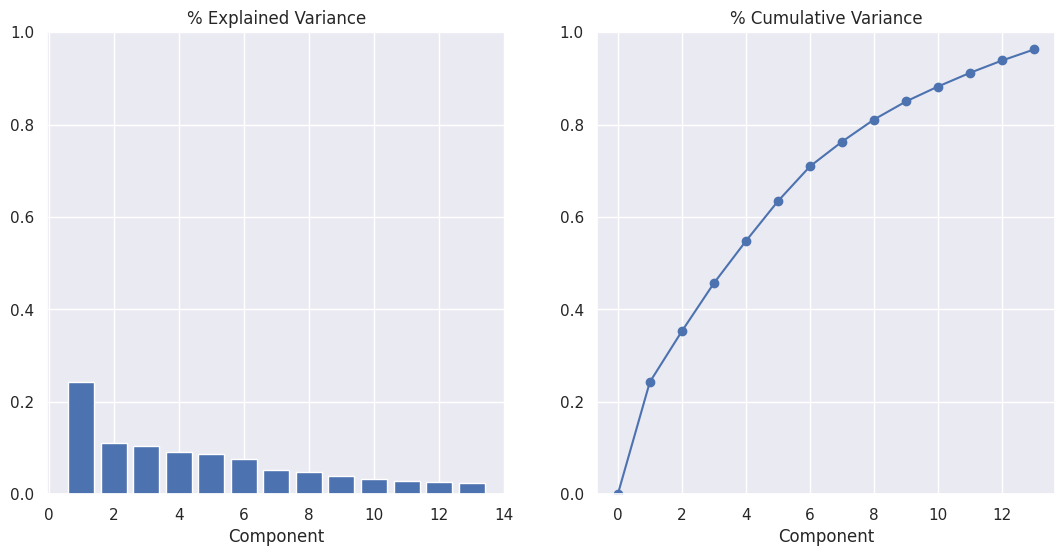

In [28]:
sns.set(style='darkgrid')
plot_variance(pca_13);

* να δοκιμάσω και τις υπόλοιπες μεθόδους pca απτό sklearn
* να αποθηκεύσω τα datasets που βγάζω μετά από κάθε μέθοδο